# Analyzing Stock Market Interventions: A CausalImpact Tutorial

This notebook is a tutorial on __[CausalImpact](https://opensource.googleblog.com/2014/09/causalimpact-new-open-source-package.html)__, a __[causal inference](https://en.wikipedia.org/wiki/Causal_inference)__ method developed by Google.

It estimates the causal effect of an intervention (e.g., a policy change, marketing campaign, or product launch) on a time series. It applies __[**Bayesian structural time-series models (BSTS)**](https://en.wikipedia.org/wiki/Bayesian_structural_time_series)__ to analyze how an intervention alters a time series, controlling for other influencing variables. By comparing actual post-intervention data to a counterfactual (what would have happened without the intervention), CausalImpact estimates the impact and provides measures of uncertainty. 

Bayesian structural time-series models, upon which the CausalImpact package is built, are a flexible and powerful approach for analyzing time series data by capturing underlying structures such as trends, seasonality, and external regressors. Its probabilistic framework allows for uncertainty estimation in predictions and effectively handles complex data patterns. With Bayesian inference, BSTS models continuously update beliefs about the system as new data arrives, making them adaptive and robust to changing conditions. They are especially useful for forecasting, causal inference, and anomaly detection, as they compare observed outcomes to predicted counterfactuals, even with incomplete data. Additionally, the Bayesian approach provides credible intervals, offering more nuanced insights into the model’s predictions and associated uncertainty, which supports better decision-making in areas like policy evaluation, demand forecasting, and campaign effectiveness analysis.

For more in-dept explanation of BSTS, and CausalImpact package, please refer to Brodersen et al: *Inferring causal impact using Bayesian structural time-series models.* Ann. Appl. Stat. 9 (1) 247 - 274, March 2015. https://doi.org/10.1214/14-AOAS788

In this tutorial, we will look whether there was an impact on Meta's stock price after the __[Facebook-Cambridge Analytica scandal.](https://en.wikipedia.org/wiki/Facebook–Cambridge_Analytica_data_scandal)__

In [1]:
import warnings
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#define dates
training_start = "2015-12-28"    # start of our dataset
training_end = "2018-03-05" # end of the "normal" period, i.e. before the intervention
treatment_start = "2018-03-12" # start of the intervention
treatment_end = "2018-07-16" # end of the intervention
end_stock = "2018-07-17" #post-intervention period

### Variable description

In this tutorial, we will use dataset that contains stock prices for the following companies: 

```
BMW.DE - BMW,
CARL-B.CO - Carlsberg,
DIS - Disney,
GE - General Electric,
GS - Goldman Sachs,
KHC - Heinz,
MCD - McDonald's,
META - Meta,
NVS - Novartis,
WMT - Walmart.
```

In [3]:
#get stock data
stocks = ["META", "WMT", "DIS", "BMW.DE", "NVS",
         "GS", "GE", "KHC", "MCD", "CARL-B.CO"]

dataset = yf.download(stocks, start=training_start, end=end_stock, interval='1wk')
dataset = dataset.iloc[:,:10] # take only "Adjusted Close"

# getting rid of unneeded level (all columns refer to adjusted close)
dataset.columns = dataset.columns.droplevel()

[*********************100%%**********************]  10 of 10 completed


In [4]:
# dataset statistics
dataset.describe()

Ticker,BMW.DE,CARL-B.CO,DIS,GE,GS,KHC,MCD,META,NVS,WMT
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,53.434698,554.218861,97.539360,111.350937,179.926362,57.336410,117.790295,146.436098,53.709057,22.653684
std,4.839653,55.848257,6.256800,27.312292,34.509564,6.688187,19.547405,29.637230,4.125099,3.493375
min,42.884342,429.737061,85.321861,59.973202,119.557793,41.978825,91.659500,94.775246,45.270294,17.231564
25%,49.290315,504.681526,92.637371,82.885519,139.898293,53.439686,99.714960,119.467003,50.425210,20.075175
50%,54.202299,549.588074,97.825241,124.344555,191.596558,58.623175,109.242458,141.124992,54.090977,21.278884
75%,57.103026,603.924698,102.654667,132.455788,206.495750,62.372389,136.237675,174.311806,57.231357,25.456007
max,62.777031,667.332214,109.834557,142.668976,233.351883,68.790276,152.197968,209.559372,64.634201,32.163944


In [5]:
# display the dataset
dataset

Ticker,BMW.DE,CARL-B.CO,DIS,GE,GS,KHC,MCD,META,NVS,WMT
Date,,,,,,,,,,
2015-12-28,59.590073,495.228424,98.361176,133.080673,150.620956,50.348270,95.339897,104.445374,54.994640,17.231564
2016-01-04,50.928970,480.270538,92.903938,121.545601,137.007187,49.254951,93.193237,97.130409,52.131138,17.861225
2016-01-11,47.620785,429.737061,87.896019,121.716484,130.045685,47.884842,92.951149,94.775246,51.281033,17.408661
2016-01-18,48.652306,437.013885,90.704216,120.648453,131.090317,51.476192,95.549698,97.739159,52.565784,17.622293
2016-01-25,46.790695,467.333954,89.693260,124.322594,135.018158,54.015751,99.891411,111.979889,49.836506,18.653940
...,...,...,...,...,...,...,...,...,...,...
2018-06-18,55.634258,640.045471,102.606842,60.459183,195.474838,47.222244,142.199585,201.326294,53.551941,25.479286
2018-06-25,53.777702,640.898193,101.130562,63.053604,190.761398,46.930874,135.407150,193.921509,53.894398,25.728611
2018-07-02,55.558060,664.774109,101.101624,64.165482,191.816498,48.133667,137.766357,202.813217,55.057327,25.386168


## Exploratory Data Analysis

### Figure 1: Plotting stocks

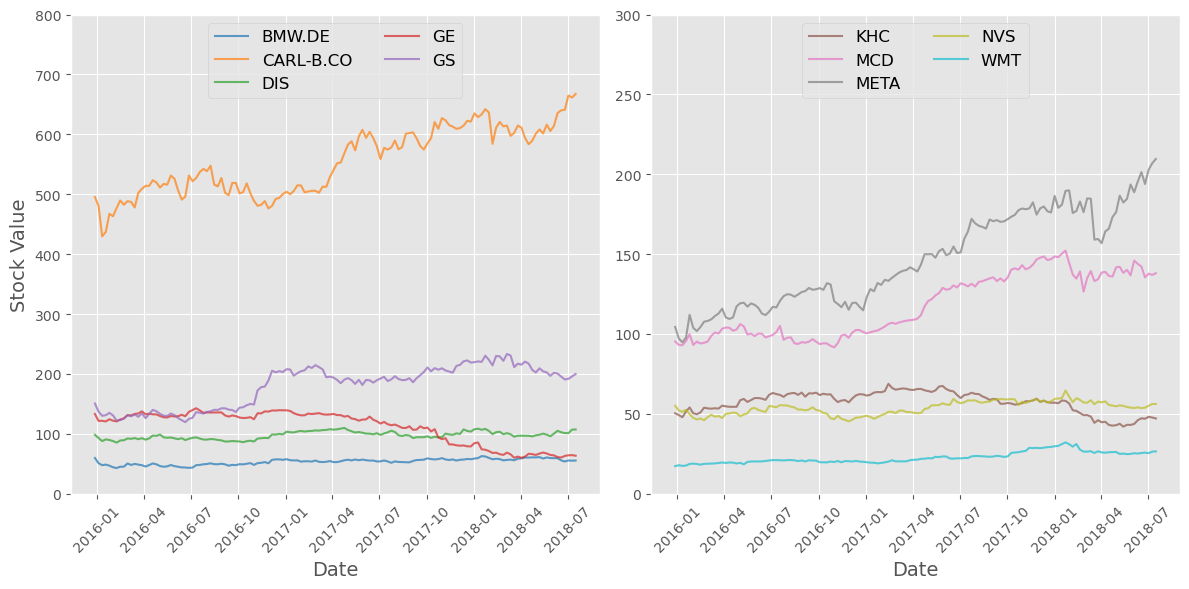

In [6]:
warnings.filterwarnings('ignore')

# Define number of stocks per subplot
n_stocks = len(dataset.columns)
n_stocks_per_subplot = 5

plot_colors = sns.color_palette("tab10", n_colors=n_stocks)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first 5 stocks in the first subplot
for i, column in enumerate(dataset.columns[:n_stocks_per_subplot]):
    sns.lineplot(x=dataset.index, y=dataset[column], label=column, color=plot_colors[i], alpha=0.7, ax=axes[0])

# Configure the first subplot
axes[0].set_ylim(0, 800)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Stock Value", fontsize=14)
axes[0].legend(title="", fontsize=12, ncol=2, loc='upper center')
axes[0].tick_params(axis='x', rotation=45)

# Plot the remaining stocks in the second subplot
for i, column in enumerate(dataset.columns[n_stocks_per_subplot:]):
    sns.lineplot(x=dataset.index, y=dataset[column], label=column, color=plot_colors[i + n_stocks_per_subplot], alpha=0.7, ax=axes[1])

# Configure the second subplot
axes[1].set_ylim(0, 300)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].set_ylabel("")
axes[1].legend(title="", fontsize=12, ncol=2, loc='upper center')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

**Figure 1:** The figure shows stock values for 10 companies (5 in each subplot) in our dataset over time. Meta's stocks are shown on the left subplot in grey. We see a steady rise in stock value over time, up until a drop in the spring of 2018 and then a rise again.

### Calculating correlations between stocks

Our dataset includes stock values for 10 companies. To streamline the analysis and ensure we use stocks that are similar to Meta's, we first calculate a correlation matrix. This matrix helps identify which stocks are most similar to Meta’s, and these stocks will serve as our control group. The matrix highlights the relationships between the stock values of different companies, making it easier to detect patterns and redundancies within the dataset. Each cell in the matrix represents the correlation coefficient between two stock values, ranging from -1 (indicating a perfect negative correlation) to +1 (indicating a perfect positive correlation).

In [7]:
# checking correlations
pd.set_option('display.max_columns', None)
dataset_corr = dataset[dataset.index < treatment_start]
dataset_corr.corr()

Ticker,BMW.DE,CARL-B.CO,DIS,GE,GS,KHC,MCD,META,NVS,WMT
Ticker,,,,,,,,,,
BMW.DE,1.000000,0.674892,0.702444,-0.557817,0.900979,0.107127,0.731254,0.748478,0.537510,0.672029
CARL-B.CO,0.674892,1.000000,0.509228,-0.764425,0.657175,0.056419,0.931387,0.933555,0.865769,0.883627
DIS,0.702444,0.509228,1.000000,-0.320905,0.776789,0.350990,0.554587,0.548770,0.331059,0.471792
GE,-0.557817,-0.764425,-0.320905,1.000000,-0.592108,0.418724,-0.822426,-0.814880,-0.705464,-0.899157
GS,0.900979,0.657175,0.776789,-0.592108,1.000000,0.174427,0.747511,0.797409,0.485084,0.691522
KHC,0.107127,0.056419,0.350990,0.418724,0.174427,1.000000,-0.059333,0.061596,-0.012951,-0.106799
MCD,0.731254,0.931387,0.554587,-0.822426,0.747511,-0.059333,1.000000,0.945877,0.834642,0.894801
META,0.748478,0.933555,0.548770,-0.814880,0.797409,0.061596,0.945877,1.000000,0.825899,0.896711
NVS,0.537510,0.865769,0.331059,-0.705464,0.485084,-0.012951,0.834642,0.825899,1.000000,0.787711


### Figure 2: Plotting correlations

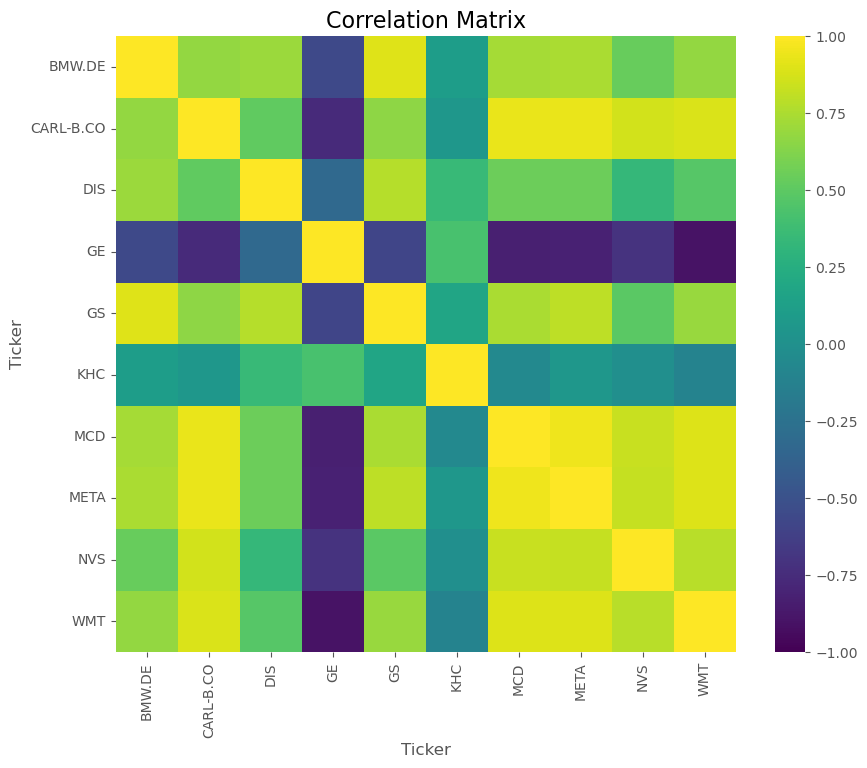

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(dataset_corr.corr(), cmap='viridis', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

**Figure 2:** The figure presents a 10x10 correlation matrix that visualizes the pairwise correlations between 10 stock values in our dataset. Positive correlations are indicated by warmer colors, while negative correlations are shown in cooler colors. The diagonal of the matrix displays perfect correlations of 1, representing the correlation of each stock with itself. The matrix reveals that Meta's stock values are most closely correlated with those of Carlsberg, Goldman Sachs, McDonald's, Walmart, and Novartis, as indicated by the brighter colors in the figure.

## Run CausalImpact on Meta's and five other stocks

In [9]:
# take only the most correlated stocks
final_series = dataset[["META", "CARL-B.CO", "GS", "MCD", "NVS", "WMT"]]

In [10]:
# prepare data for causal impact
training_start = pd.to_datetime(training_start)
training_end = pd.to_datetime(training_end)
treatment_start = pd.to_datetime(treatment_start)
treatment_end = pd.to_datetime(treatment_end)

pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [11]:
# run causal impact
warnings.filterwarnings('ignore')

impact = CausalImpact(data = final_series, 
                      pre_period = pre_period, 
                      post_period = post_period)
impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26826D-01    |proj g|=  9.45652D-01

At iterate    5    f= -5.65337D-01    |proj g|=  4.92907D-01

At iterate   10    f= -6.18559D-01    |proj g|=  1.30848D+00

At iterate   15    f= -6.35710D-01    |proj g|=  1.68083D-01

At iterate   20    f= -6.36204D-01    |proj g|=  6.23069D-03

At iterate   25    f= -6.36216D-01    |proj g|=  9.82512D-04

At iterate   30    f= -6.36216D-01    |proj g|=  4.44680D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


### Figure 3: Plot results

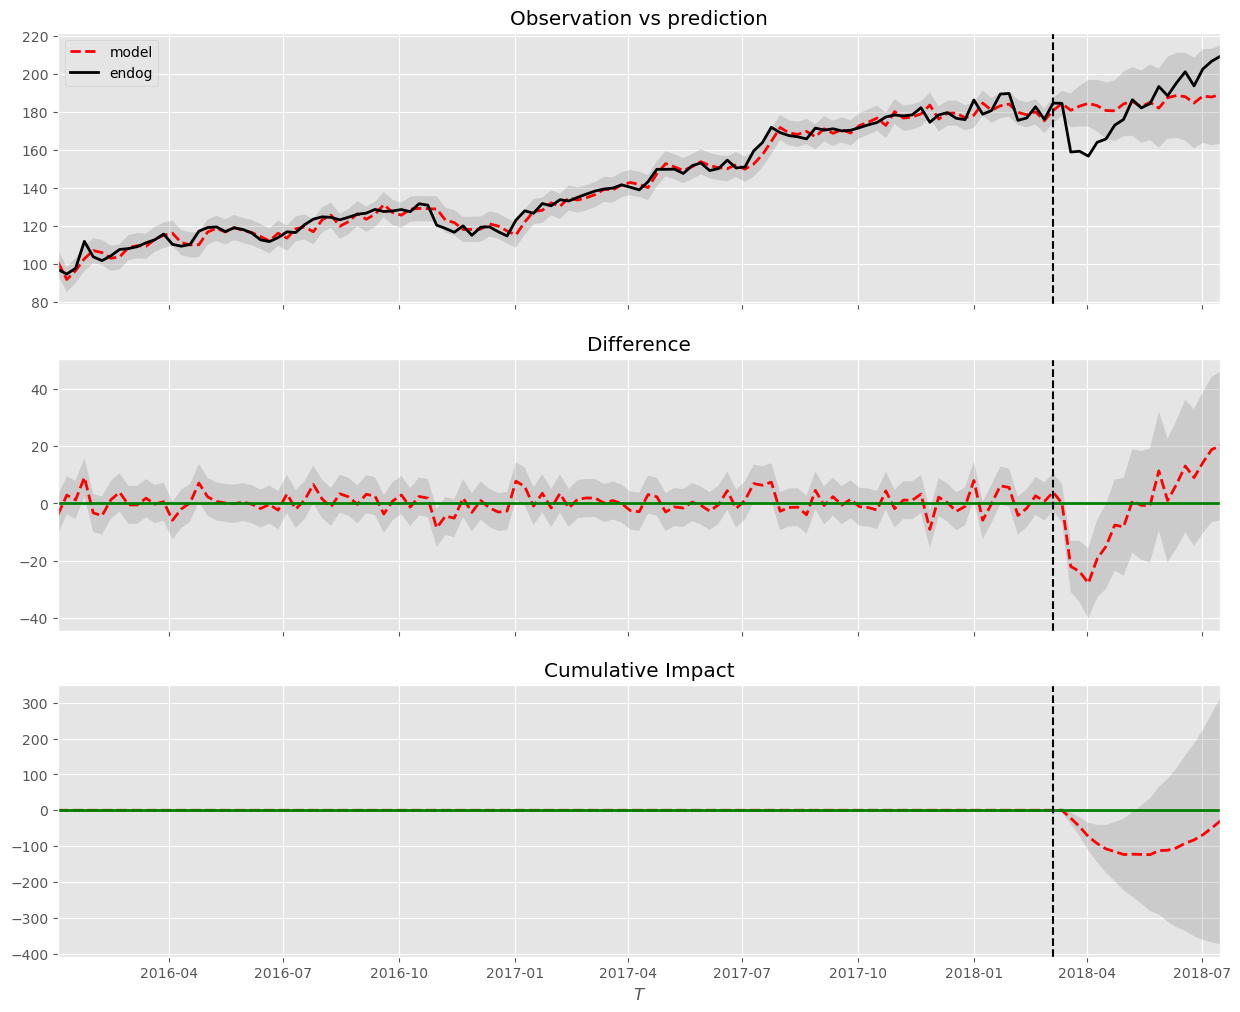

In [12]:
#plot and interpret the results using CausalImpact package
impact.plot()

**Figure 3:** This figure presents the results of the causal analysis. The upper subplot displays observed values of Meta’s stock (black) alongside the modeled values (dashed red) over time. A significant divergence between observed and predicted values occurs after the intervention (the Cambridge Analytica scandal), marked by the vertical dashed black line. The middle subplot shows the difference between observed and predicted time-series, represented by the dashed red line. The lower subplot illustrates the cumulative impact of the intervention, also shown with a dashed red line. The impact shows an immediate decrease following the intervention, but it returns to "normal" after 3-4 months.

In [13]:
print(impact.summary())
print(impact.summary('report'))

                               Average      Cumulative
Actual                             183            3485
Predicted                          184            3514
95% CI                      [166, 203]    [3170, 3859]
                                                      
Absolute Effect                     -1             -29
95% CI                       [16, -19]     [315, -374]
                                                      
Relative Effect                  -0.8%           -0.8%
95% CI                  [9.0%, -10.6%]  [9.0%, -10.6%]
                                                      
P-value                           0.0%                
Prob. of Causal Effect          100.0%                
None
During the post-intervention period, the response             variable had an average value of             approx. 183.
By contrast, in  the absence of an intervention, we would have expected an average response of 184. The 95% interval of
this counterfactual prediction is [166, 

## Conclusion

In this notebook, we demonstrated how to use Google's CausalImpact package. It is user-friendly, especially for beginners in causal analysis. The analysis, which utilized Bayesian Structural Time Series models showed how interventions, such as the Cambridge Analytica scandal, impacted Meta's stock values. The package is easy to use and helpful for understanding the effects of specific events. It can be applied to various scenarios where analyzing the impact of changes is important, such as public health interventions, policy changes, economic events, or marketing campaigns.